In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Dense, Dropout, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [2]:
# MNIST 데이터셋 불러오기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# 생성자 네트워크 생성
def create_generator():
    generator = Sequential()
    generator.add(Dense(7 * 7 * 256, input_dim = 100))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7,7,256)))

    generator.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding="SAME", use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))
    
    generator.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME", use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding="SAME", use_bias=True, activation="tanh"))

    return generator

g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0

In [4]:
# 판별자 네트워크 생성
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5,5), strides=(2,2), padding="SAME", input_shape=[28,28,1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding="SAME"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1))

    return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [5]:
# 손실 함수 정의
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    final_loss = real_loss + fake_loss
    return final_loss

def G_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)


In [6]:
# 옵티마이저 정의
G_optimizer = tf.keras.optimizers.Adam()
D_optimizer = tf.keras.optimizers.Adam()

In [7]:
# 파라미터 초기값 설정
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 1

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [8]:
# 모델 훈련을 위한 파이프라인 정의
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [9]:
# 생성된 이미지 출력 함수
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap="rainbow")

In [10]:
# 모델 훈련 함수
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        
        if epoch % 10 == 0:
            generate_images(generator, epoch + 1, seed)
        print('에포크 {}은/는 {} 초'.format(epoch +1, time.time()-start))
    generate_images(generator, epochs, seed)

에포크 1은/는 19.832634449005127 초
에포크 2은/는 1.919691801071167 초
에포크 3은/는 1.847571849822998 초
에포크 4은/는 1.844928503036499 초
에포크 5은/는 1.8632965087890625 초
에포크 6은/는 1.8484013080596924 초
에포크 7은/는 1.8532519340515137 초
에포크 8은/는 1.8475241661071777 초
에포크 9은/는 1.8495700359344482 초
에포크 10은/는 1.8580167293548584 초
에포크 11은/는 2.035404682159424 초
에포크 12은/는 1.8545475006103516 초
에포크 13은/는 1.843313455581665 초
에포크 14은/는 1.844531774520874 초
에포크 15은/는 1.843897819519043 초
에포크 16은/는 1.8455309867858887 초
에포크 17은/는 1.8521981239318848 초
에포크 18은/는 1.873626947402954 초
에포크 19은/는 1.8431575298309326 초
에포크 20은/는 1.8457984924316406 초
에포크 21은/는 2.0238842964172363 초
에포크 22은/는 1.854487657546997 초
에포크 23은/는 1.851712942123413 초
에포크 24은/는 1.850616455078125 초
에포크 25은/는 1.8429694175720215 초
에포크 26은/는 1.8533546924591064 초
에포크 27은/는 1.8450822830200195 초
에포크 28은/는 1.8486933708190918 초
에포크 29은/는 1.848304033279419 초
에포크 30은/는 1.850499153137207 초


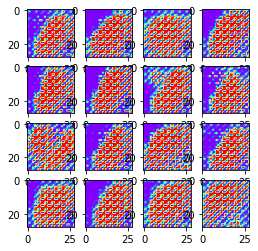

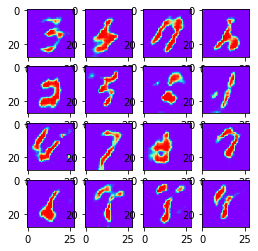

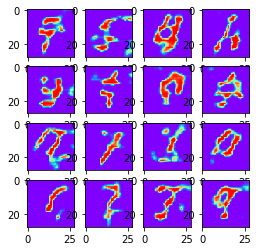

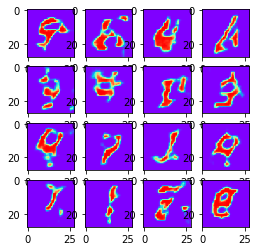

In [11]:
train_GAN(train_dataset, 30)